In [2]:
import os
import pandas as pd
import random
import json
from datetime import datetime

import duckdb

import yaml

db_path = "/home/max/drive/dshs/Creativity/code/lsa-creativity/rating_study/statsbomb_event_data_backup.duckdb"


In [60]:
# Load configuration from YAML file
with open('config.yaml', 'r') as file:
    config_data = yaml.safe_load(file)

db_path = config_data['paths']['db_path']
video_path = config_data['paths']['video_path']

user_id = 'giha3042'

## Save ratings and calculate rating means per event

In [3]:
userdata_path = 'user_data/'
ratings_path = 'user_ratings/'

def load_json_files_with_datetime(path, file_type='ratings'):
    """
    Load all JSON files from a directory and add creation datetime.
    
    Parameters:
    - path: directory path containing JSON files
    - file_type: string to identify the type of data (for column naming)
    
    Returns:
    - DataFrame with all records and file_created_at column
    """
    all_data = []
    
    for filename in os.listdir(path):
        if filename.endswith('.json'):
            filepath = os.path.join(path, filename)
            
            # Get file modification time (preserved when copying between machines)
            modification_time = os.path.getmtime(filepath)
            creation_datetime = datetime.fromtimestamp(modification_time)
            
            # Load JSON file
            with open(filepath, 'r') as f:
                data = json.load(f)
            
            # Handle both single dict and list of dicts
            if isinstance(data, dict):
                data = [data]
            elif not isinstance(data, list):
                data = [{'content': data}]
            
            # Add metadata to each record
            for record in data:
                record['file_created_at'] = creation_datetime
                record['filename'] = filename
            
            all_data.extend(data)
    

    df = pd.DataFrame(all_data)
    return df


In [4]:

# Load ratings
df_ratings = load_json_files_with_datetime(ratings_path, 'ratings')
#df_ratings.to_csv('output/ratings.csv')
print(f"Loaded {len(df_ratings)} ratings from {df_ratings['filename'].nunique()} files")
print(f"Number of rated actions: {df_ratings['id'].nunique()}")

# Load user data
df_users = load_json_files_with_datetime(userdata_path, 'users')
#df_users.to_csv('output/users.csv')
print(f"\nLoaded {len(df_users)} user records from {df_users['filename'].nunique()} files")
print(f"Number of unique users: {df_users['user_id'].nunique()}")


Loaded 2826 ratings from 2826 files
Number of rated actions: 1575

Loaded 21 user records from 21 files
Number of unique users: 10


In [13]:
df_mean_ratings = df_ratings.groupby('id').agg(
    num_ratings=('action_rating', 'count'),
    mean_rating=('action_rating', 'mean'),
    std_rating=('action_rating', 'std'),
    mean_technical_correctness=('technical_correctness', 'mean'),
    std_technical_correctness=('technical_correctness', 'std'),
    mean_aesthetic_appeal=('aesthetic_appeal', 'mean'),
    std_aesthetic_appeal=('aesthetic_appeal', 'std'),
    mean_action_not_recognized=('action_not_recognized', 'mean')
)

In [10]:
df_ratings.head()

,user_id,id,action_rating,technical_correctness,aesthetic_appeal,action_not_recognized,file_created_at,filename
0,clpe1410,0881f9d1-1e9d-446b-b6a4-fd45c63508e5,3.0,5.0,2.0,False,2025-10-18 17:18:15.440122,clpe1410_0881f9d1-1e9d-446b-b6a4-fd45c63508e5....
1,anma2416,da098f44-2f47-49c5-aa41-b54954362409,1.0,3.0,1.0,False,2025-10-16 13:59:13.000000,anma2416_da098f44-2f47-49c5-aa41-b54954362409....
2,mana12312,2843ae21-38e2-468e-9425-29cf5c9e442f,1.0,1.0,2.0,False,2025-10-15 11:15:01.000000,mana12312_2843ae21-38e2-468e-9425-29cf5c9e442f...
3,mana12312,02da8947-987e-4c02-9b62-09198e312169,5.0,6.0,4.0,False,2025-10-16 11:03:10.000000,mana12312_02da8947-987e-4c02-9b62-09198e312169...
4,mana12312,0969fb41-c9c7-4b5d-ade9-9e601be5a2c9,2.0,5.0,2.0,False,2025-10-16 11:04:54.000000,mana12312_0969fb41-c9c7-4b5d-ade9-9e601be5a2c9...


In [ ]:

# Generate log file with statistics
log_path = 'output/rating_log.txt'
with open(log_path, 'w') as log_file:
    log_file.write("=" * 60 + "\n")
    log_file.write("CREATIVITY RATING APP - DATA EXPORT LOG\n")
    log_file.write("=" * 60 + "\n")
    log_file.write(f"Generated at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")

    # 1. Number of unique actions rated
    num_unique_actions = df_ratings['id'].nunique()
    log_file.write(f"Number of unique actions rated: {num_unique_actions}\n\n")

    # 2. Number of raters involved
    num_unique_raters = df_users['user_id'].nunique()
    log_file.write(f"Number of raters involved: {num_unique_raters}\n\n")

    # 3. Value counts of value counts for 'id' in df_ratings
    # First, count how many times each action ID has been rated
    id_rating_counts = df_ratings['id'].value_counts()
    # Then, count how many IDs have each rating count (e.g., how many IDs rated once, twice, etc.)
    rating_frequency_distribution = id_rating_counts.value_counts().sort_index()

    log_file.write("Rating frequency distribution:\n")
    log_file.write("-" * 40 + "\n")
    log_file.write(f"{'Times Rated':<15} {'Number of Actions':<20}\n")
    log_file.write("-" * 40 + "\n")
    for times_rated, num_actions in rating_frequency_distribution.items():
        log_file.write(f"{times_rated:<15} {num_actions:<20}\n")

    log_file.write("\n" + "=" * 60 + "\n")

print(f"\n[INFO] Log file created: {log_path}")

In [15]:
# Convert list of video filenames to event IDs (removing .mp4 extension)
event_id_str = ', '.join(f"'{event_id.replace('.mp4', '')}'" for event_id in event_ids)

# Fetch metadata for all actions from included videos
query = f"SELECT * FROM events WHERE id IN ({event_id_str})"
df_actions = conn.execute(query).fetchdf()
conn.close()


In [16]:
df_actions

,player,jersey_number,id,match_id,period,minute,second,timestamp,possession,possession_team,duration,team,type,shot_body_part,pass_body_part
0,Abdul Rahman Baba,17,09046541-0097-446a-a446-fe49edcb06b9,3857293,1,0,39,00:00:39.839,3,Ghana,1.149274,Ghana,Pass,None,Left Foot
1,Abdul Rahman Baba,17,eb66c128-fe5f-47f2-a80b-0ba4827409fb,3857293,2,65,51,00:20:51.373,124,Ghana,1.244807,Ghana,Pass,None,Left Foot
2,Abdul Rahman Baba,17,ff4f058a-a499-4d70-bc7b-3556286c353c,3857293,2,77,10,00:32:10.264,149,Ghana,1.334563,Ghana,Pass,None,Left Foot
3,Abdul Rahman Baba,17,6dfd35c3-3a7c-4512-8b8b-a11820ffb279,3857293,1,35,38,00:35:38.321,65,Ghana,0.000000,Ghana,Dribble,None,None
4,Abdul Rahman Baba,17,c378aa58-d7b4-4ca1-9f16-ad3b46566f87,3857293,2,93,53,00:48:53.438,174,Ghana,0.000000,Ghana,Dribble,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1516,Siyanda Xulu,5,82d5ff6c-66b2-4076-ac39-92e69dae5b3e,3923880,1,16,46,00:16:46.412,26,South Africa,0.632062,South Africa,Pass,None,Right Foot
1517,Siyanda Xulu,5,b98b49e4-0d00-4463-ac3e-ad78a70f576d,3923880,1,21,6,00:21:06.670,30,South Africa,0.624819,South Africa,Pass,None,Right Foot
1518,Siyanda Xulu,5,5925ae7c-97d7-4499-95ba-6381a943aa20,3923880,2,55,4,00:10:04.095,81,South Africa,1.215914,South Africa,Pass,None,Right Foot
1519,Mihlali Samson Mayambela,21,3c405073-58a4-4780-8013-88780f9d8649,3923880,1,8,45,00:08:45.238,11,South Africa,0.000000,South Africa,Dispossessed,None,None


In [27]:
import mplsoccer
import matplotlib.pyplot as plt

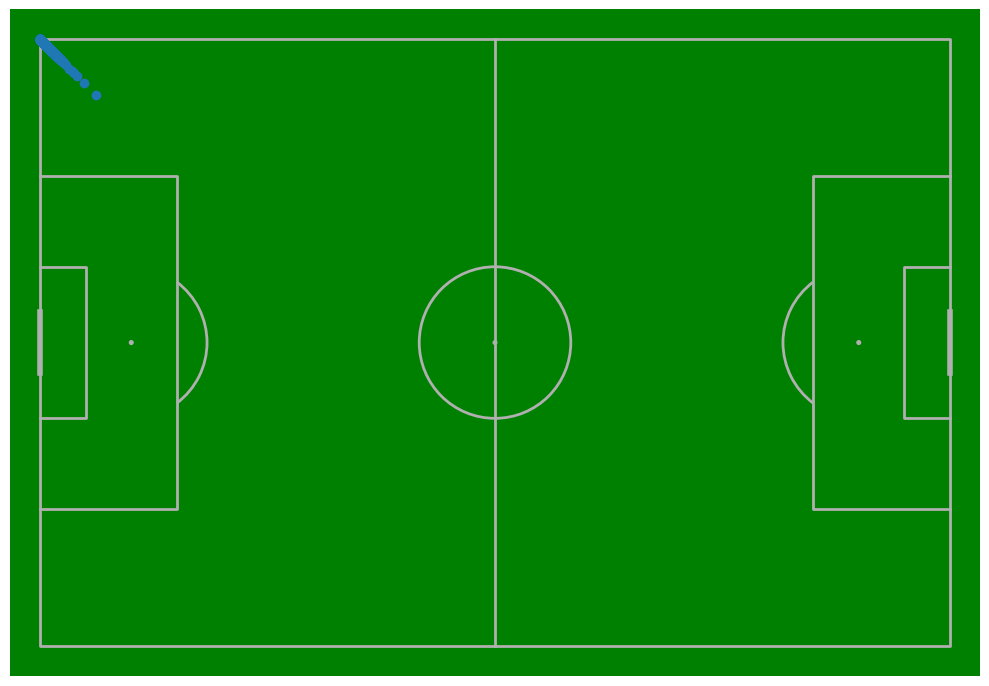

In [33]:
pitch = mplsoccer.Pitch(pitch_type = "statsbomb", pitch_color="green")
fig, ax = pitch.draw(figsize=(10, 7))
ax.scatter(df_actions.duration, df_actions.duration)

NameError: name 'plt' is not defined